In [1]:
import os
from pathlib import Path

#auto load the eemeter module
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np

from hourly_test_utils import *
from applied_data_science.bigquery.data import Meter_Data
from eemeter import eemeter as em
from eemeter.common.metrics import BaselineTestingMetrics as Metrics

import multiprocessing as mp


In [2]:
settings = em.HourlySettings(
    TRAIN_FEATURES=['ghi'],
    LAGGED_FEATURES=None, # 'ghi'
    WINDOW=None,
    OUTPUT_FEATURES=['start_local', 'temperature', 'ghi', 'clearsky_ghi', 'observed', 'predicted', 'month'],
    SUPPLEMENTAL_DATA=False,
    ALPHA=0.1,
    L1_RATIO=0.1,
    SELECTION="cyclic",
    MAX_ITER=1000,
    SEED=42
)

In [9]:
subsamples = range(1,7)
solar_meters = [True, False]
kwargs = {
    'settings': settings,
    'subsamples': subsamples,
    'solar_meters': solar_meters
}
prf = Population_Run_Features(**kwargs)


In [10]:
prf.run()

In [19]:
calc_id_kf_num = 0
train_errors = []
test_errors = []
for res in prf.results:
    _, _, errors = res
    if (errors!=None) and (errors['train'][0]!= np.inf) and (errors['test'][0]!= np.inf):

        calc_id_kf_num += 1
        train_errors.append(errors['train'])
        test_errors.append(errors['test'])
print(len(prf.results))
print(f"Calculated {calc_id_kf_num} id/kfold pairs")
print('avg. train pnrmse:', np.mean(train_errors))
print('avg. test pnrmse:', np.mean(test_errors))

35946
Calculated 35939 id/kfold pairs
avg. train pnrmse: 1.2821017269352961
avg. test pnrmse: 1.8609864214323966


Calculated 2994 id/kfold pairs
avg. train pnrmse: 0.742258580754257
avg. test pnrmse: 0.9811779135988258


In [11]:
pr = Population_Run(settings, data)
pr.run()

In [12]:
train_error = pr.errors['train']
test_error = pr.errors['test']
print(f"Train Error New Model: {np.mean(train_error['new_model'])}")
print(f"Train Error OEEM: {np.mean(train_error['oeem'])}")

print("_____________________________")
print(f"Test Error New Model: {np.mean(test_error['new_model'])}")
print(f"Test Error OEEM: {np.mean(test_error['oeem'])}")

#test error improvement percentage
improvement = -(np.mean(test_error['new_model']) - np.mean(test_error['oeem'])) / np.mean(test_error['oeem'])
print(f"Test Error Improvement: {improvement * 100:.2f}%")

Train Error New Model: 0.7425488046391864
Train Error OEEM: 0.6798872227638726
_____________________________
Test Error New Model: 0.9815834518352167
Test Error OEEM: 1.007705690433044
Test Error Improvement: 2.59%


In [13]:
tt = 0
ct = 0
aft = 0
ldt = 0

for i in range(len(pr.results)):
    tt += pr.results[i][1]
    ct += pr.results[i][2]
    aft += pr.results[i][4]
    ldt += pr.results[i][5]

print(f"Total Time: {tt:.2f} seconds")
print(f"Compute Time: {ct:.2f} seconds")
print(f"Average Fit Time: {aft:.2f} seconds")
print(f"Average Load Time: {ldt:.2f} seconds")

Total Time: 4910.76 seconds
Compute Time: 1105.85 seconds
Average Fit Time: 41.90 seconds
Average Load Time: 3804.91 seconds


Total Time: 8420.99 seconds
Compute Time: 6745.66 seconds
Average Fit Time: 271.79 seconds
Average Load Time: 1675.34 seconds

In [6]:
sid = ids[20]
lat = meta.loc[meta.index == sid].iloc[0]['station_latitude']
lon = meta.loc[meta.index == sid].iloc[0]['station_longitude']
sd = subsample_df.loc[sid].copy()
metadata = {'lat': lat, 'lon': lon, 'sid': sid}

data_loader = MCE_Data_Loader_Test(settings)
# sid, df_trains, df_tests = data_loader.get_all_cleaned_data(metadata, sd)
sid, train_datasets, test_datasets, df_trains, df_tests = data_loader.get_all_cleaned_data_new(metadata, sd)

In [7]:
sid

'None-1386993605_1-1386993605_1'

In [6]:
settings = em.HourlySettings(
    TRAIN_FEATURES=['ghi'],
    LAGGED_FEATURES=None, # 'ghi'
    WINDOW=None,
    OUTPUT_FEATURES=['start_local', 'temperature', 'ghi', 'clearsky_ghi', 'observed', 'predicted', 'month'],
    SUPPLEMENTAL_DATA=False,
    ALPHA=0.1,
    L1_RATIO=0.1,
    SELECTION="cyclic",
    MAX_ITER=1000,
    SEED=42
)
import time

tic = time.time()
data_loader = MCE_Data_Loader_Test(settings)
sid, train_datasets, test_datasets, df_trains, df_tests = data_loader.get_all_cleaned_data_new(metadata, sd)    
load_data_tac = time.time()
errors = {'train': {
    'new_model': [],
    'oeem': []
}, 'test': {
    'new_model': [],
    'oeem': []
}} 
calc_tic = time.time()
avg_fit_time =0
for k in range(len(df_trains)):
    tic2 = time.time()
    model = em.HourlyModelTest(settings=settings)
    X_train, y_train, y_scaler = train_datasets["X"][k], train_datasets["y"][k], train_datasets["y_scalar"][k]
    X_test, y_test = test_datasets["X"][k], test_datasets["y"][k]
    model.fit(X_train, y_train)
    
    tak2 = time.time()
    avg_fit_time += tak2 - tic2
    iqr = df_trains[k]["observed"].quantile(0.75) - df_trains[k]["observed"].quantile(0.25)

    for train_test in ['train', 'test']:
        if train_test == 'train':
            y_pred = model.predict(X_train, y_scaler)
            df_trains[k]["predicted"] = y_pred
            new_df = df_trains[k].copy()
        else:
            y_pred = model.predict(X_test, y_scaler)
            df_tests[k]["predicted"] = y_pred
            new_df = df_tests[k].copy()
        
        metrics = Metrics(df=new_df, num_model_params=model.num_model_params)
        obs = metrics.observed
        ct = metrics.caltrack
                    
        err = metrics.rmse / iqr
        errors[train_test]['new_model'].append(err)

        ct_pnrmse = np.sqrt(np.mean((obs.values - ct.values)**2))
        ct_pnrmse = ct_pnrmse / iqr
        errors[train_test]['oeem'].append(ct_pnrmse)

avg_fit_time = avg_fit_time / len(df_trains)
load_data_time = load_data_tac - tic
tak = time.time()
total_time = tak - tic
calc_time = tak - calc_tic

In [9]:
print(f"Total Time: {total_time:.2f} seconds")
print(f"Compute Time: {calc_time:.2f} seconds")
print(f"Average Fit Time: {avg_fit_time:.2f} seconds")
print(f"Load Data Time: {load_data_time:.2f} seconds")

train_error = errors['train']
test_error = errors['test']
print(f"Train Error New Model: {np.mean(train_error['new_model'])}")
print(f"Train Error OEEM: {np.mean(train_error['oeem'])}")

print("_____________________________")
print(f"Test Error New Model: {np.mean(test_error['new_model'])}")
print(f"Test Error OEEM: {np.mean(test_error['oeem'])}")

#test error improvement percentage
improvement = -(np.mean(test_error['new_model']) - np.mean(test_error['oeem'])) / np.mean(test_error['oeem'])
print(f"Test Error Improvement: {improvement * 100:.2f}%")

Total Time: 4.01 seconds
Compute Time: 1.22 seconds
Average Fit Time: 0.07 seconds
Load Data Time: 2.78 seconds
Train Error New Model: 0.4768643349009365
Train Error OEEM: 0.42419925788368124
_____________________________
Test Error New Model: 0.5713081133002695
Test Error OEEM: 0.5526538143582257
Test Error Improvement: -3.38%


In [26]:
settings = em.HourlySettings(
    TRAIN_FEATURES=['ghi'],
    LAGGED_FEATURES=None, # 'ghi'
    WINDOW=None,
    OUTPUT_FEATURES=['start_local', 'temperature', 'ghi', 'clearsky_ghi', 'observed', 'predicted', 'month'],
    SUPPLEMENTAL_DATA=False,
    ALPHA=0.1,
    L1_RATIO=0.1,
    SELECTION="cyclic",
    MAX_ITER=1000,
    SEED=42
)

err_type = 'pnrmse'

tr_errors = []
te_errors = []
# for k in range(len(df_trains)):

for k in range(1):
    model = em.HourlyModel(settings=settings)

    model.fit(df_trains[k])
    tr_errors.append(getattr(model.baseline_metrics, err_type))

    # new_df = model.predict(df_trains[k])
    new_df = model.predict(df_tests[k])
    num_model_parameters = model.baseline_metrics.num_model_params
    tr_metrics = Metrics(df=new_df, num_model_params=num_model_parameters)

    if err_type == "cvrmse":
        err = tr_metrics.rmse / model.baseline_metrics.observed.mean
    elif err_type == "pnrmse":
        err = tr_metrics.rmse / model.baseline_metrics.observed.iqr

    te_errors.append(err)

# plt.plot(tr_errors, label='train')
# plt.plot(te_errors, label='test')
# plt.legend()
print(np.mean(tr_errors), np.mean(te_errors))

0.4526902652299314 0.5307220100970872


In [5]:
settings = em.HourlySettings(
    TRAIN_FEATURES=['ghi'],
    LAGGED_FEATURES=None, # 'ghi'
    WINDOW=None,
    OUTPUT_FEATURES=['start_local', 'temperature', 'ghi', 'clearsky_ghi', 'observed', 'predicted', 'month'],
    SUPPLEMENTAL_DATA=False,
    ALPHA=0.1,
    L1_RATIO=0.1,
    SELECTION="cyclic",
    MAX_ITER=1000,
    SEED=42
)

arglist = []
for sid in ids:
    lat = meta.loc[meta.index == sid].iloc[0]["station_latitude"]
    lon = meta.loc[meta.index == sid].iloc[0]["station_longitude"]
    sd = subsample_df.loc[sid].copy()
    metadata = {"lat": lat, "lon": lon, "sid": sid}
    data_loader = MCE_Data_Loader_Test()
    arglist.append([sid, sd, metadata, data_loader, settings])


In [6]:
results = []
with mp.Pool(processes=mp.cpu_count() - 1) as pool:
    results = pool.map(train_dec, arglist[0:10])

In [8]:
tr_nm_err = []
te_nm_err = []
tr_ct_err = []
te_ct_err = []
for res in results:
    tr_nm_err.append(np.mean(res[3]['train']['new_model']))
    te_nm_err.append(np.mean(res[3]['test']['new_model']))

    tr_ct_err.append(np.mean(res[3]['train']['oeem']))
    te_ct_err.append(np.mean(res[3]['test']['oeem']))

print('train error for new model:', np.mean(tr_nm_err))
print('train error for oeem:', np.mean(tr_ct_err))

print("___________________________")

print('test error for new model:', np.mean(te_nm_err))
print('test error for oeem:', np.mean(te_ct_err))
    

train error for new model: 0.689627944945471
train error for oeem: 0.6448409264278361
___________________________
test error for new model: 0.7538136205685182
test error for oeem: 0.7890057633734635


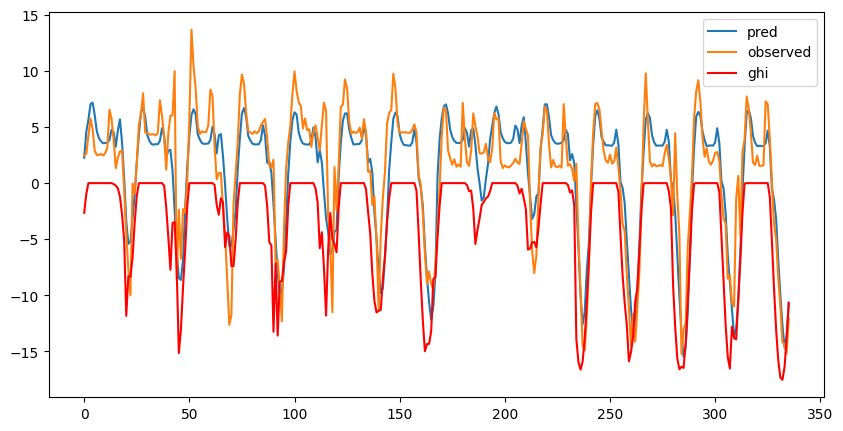

In [ ]:
start = 24*70
window = 24*14
end = start + window
plt.rcParams['figure.figsize'] = [10, 5]

plt.plot(new_df['predicted'][start:end].values, label='pred')
plt.plot(new_df['observed'][start:end].values, label='observed')
plt.plot(-new_df['ghi'][start:end].values*20, label='ghi', c='r')
plt.legend()
plt.show()

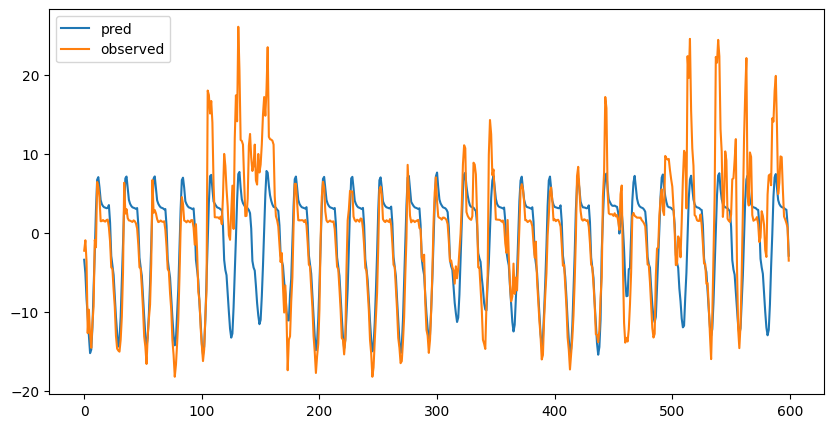

In [ ]:
start = 4000
window = 600
end = start + window
plt.rcParams['figure.figsize'] = [10, 5]

plt.plot(new_df['predicted'][start:end].values, label='pred')
plt.plot(new_df['observed'][start:end].values, label='observed')
# plt.plot(-new_df['ghi'][start:end].values*20, label='ghi', c='r')
plt.legend()
plt.show()

In [ ]:
# Testing Serialization

# json = model.to_json()
# new_model = em.HourlyModel.from_json(json)
# new_model.baseline_metrics.observed.iqr

7.154200196266174